""

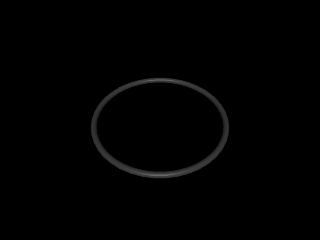

In [1]:
import time 
import itertools 
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt
import mujoco

np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Defining the wheel here...
xml = """
<mujoco>
    <asset>
        <mesh name="cyrwheel_mesh" file="cyrwheel.obj"/>
    </asset>
    <worldbody>
        <light name="top" pos="0.1 0.1 0.1"/>
        <body name="cyrwheel" pos="0 0 0">
            <geom type="mesh" mesh="cyrwheel_mesh" size=".2 .2 .2"/>
        </body>
        <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    </worldbody>
    
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(xml) # this makes a model out of the xml such that we can use it. 

data = mujoco.MjData(model)

# Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)
# media.show_image(renderer.render())

mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [4]:
xml = """
<mujoco>
    <option integrator="RK4"/>
    <asset>
        <mesh name="cyrwheel_mesh" file="cyrwheel.obj"/>
        <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" rgb2=".2 .3 .4" width="300" height="300"/>
        <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
    </asset>
    <worldbody>
        <geom size="2 2 .01" type="plane" material="grid"/>
        <light name="top" pos="0 0 1"/>
        <camera name="closeup" pos="0 -105 105" xyaxes="1 0 0 0 0 1"/>
        <body name="cyrwheel" pos="0 0 0.2">
            <freejoint/>
            <geom type="mesh" mesh="cyrwheel_mesh" size="0.2 0.2 0.2"/>
        </body>
    </worldbody>
    <keyframe>
        <key name="spinning" qp="1.5708 0 0 0 0 0 1" qvel="0 0 0 0 1 200" />
    </keyframe>
</mujoco>

"""
model = mujoco.MjModel.from_xml_string(xml)
renderer = mujoco.Renderer(model)
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera="closeup")
media.show_image(renderer.render())

ValueError: XML Error: Schema violation: unrecognized attribute: 'qp'

Element 'key', line 19


In [6]:
duration = 7    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data, "closeup")
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)

RuntimeError: Error writing '/var/folders/rk/g3gqh7090yqc7kf17z559cq00000gn/T/tmpz0geax7n/file.mp4': Unrecognized option 'qp'.
Error splitting the argument list: Option not found
